In [1]:
import u_net
import os
import cv2
import numpy as np
import tensorflow as tf
import random
from tqdm import tqdm
print(tf.config.list_physical_devices('GPU'))

X_TRAIN_PATH = '../datasets/Dataset_UHCSDB/Patched/images_patched/'
Y_TRAIN_PATH = '../datasets/Dataset_UHCSDB/Patched/labels_png_patched/'

n_classes = 4

def load_and_augment_data(image_path, mask_path):
    images = []
    masks = []
    angles = [90, 180, 270]

    for file in os.listdir(image_path):
        if file.endswith('.png'):
            img = cv2.imread(os.path.join(image_path, file), cv2.IMREAD_GRAYSCALE)
            images.append(img)

    for file in os.listdir(mask_path):
        if file.endswith('.png'):
            mask = cv2.imread(os.path.join(mask_path, file), cv2.IMREAD_GRAYSCALE)
            masks.append(mask)

    augmented_images = []
    augmented_masks = []

    for img, mask in tqdm(zip(images, masks), total=len(images), desc="Augmenting data"):
        augmented_images.append(img)
        augmented_masks.append(mask)
        #for angle in angles:
        #    rotated_img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE if angle == 90 else cv2.ROTATE_180 if angle == 180 else cv2.ROTATE_90_COUNTERCLOCKWISE)
        #    rotated_mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE if angle == 90 else cv2.ROTATE_180 if angle == 180 else cv2.ROTATE_90_COUNTERCLOCKWISE)
        #    augmented_images.append(rotated_img)
        #    augmented_masks.append(rotated_mask)

    return augmented_images, augmented_masks

train_images, train_masks = load_and_augment_data(X_TRAIN_PATH, Y_TRAIN_PATH)

print("Number of training images:", len(train_images))
print("Shape of a single training image:", train_images[0].shape)
print("Number of training masks:", len(train_masks))
print("Shape of a single training mask:", train_masks[0].shape)

2025-06-01 14:43:47.185740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748781827.293878     720 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748781827.326736     720 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748781827.592749     720 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748781827.592770     720 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748781827.592771     720 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Augmenting data: 100%|██████████| 96/96 [00:00<00:00, 1270199.32it/s]

Number of training images: 96
Shape of a single training image: (322, 322)
Number of training masks: 96
Shape of a single training mask: (322, 322)


In [2]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

# Turn the lists into numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print("Class values in Y_train:")
unique_classes = np.unique(Y_train)
print(unique_classes)   # [0 1 2 3]

# print shape of X_train and Y_train
print("Shape of X_train:", X_train.shape)  # (number_of_images, height, width, channels)
print("Shape of Y_train:", Y_train.shape)  # (number_of_images, height, width, channels)
# both are (76, 322, 322)

# Convert Y_train to categorical
from keras.utils import to_categorical
train_masks_cat = to_categorical(Y_train, num_classes=n_classes)
Y_train_cat = train_masks_cat.reshape((Y_train.shape[0], Y_train.shape[1], Y_train.shape[2], n_classes))

test_masks_cat = to_categorical(Y_test, num_classes=n_classes)
Y_test_cat = test_masks_cat.reshape((Y_test.shape[0], Y_test.shape[1], Y_test.shape[2], n_classes))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train.flatten()
)
# Normalize class weights
class_weights = class_weights / class_weights.sum()
print("Class weights:", class_weights)  # [0.338 1.862 2.514 9.083]

Class values in Y_train:
[0 1 2 3]
Shape of X_train: (76, 322, 322)
Shape of Y_train: (76, 322, 322)
Class weights: [0.02452412 0.13497139 0.18221428 0.65829021]


In [3]:
model = u_net.unet_model_same_padding()
#model.compile(optimizer='adam', loss=[u_net.make_weighted_jaccard_loss(class_weights=class_weights)], metrics=[u_net.jaccard_coeff_multiclass])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[u_net.jaccard_coeff_multiclass])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='categorical_focal_crossentropy', metrics=[u_net.jaccard_coeff_multiclass])

os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

LR = 0.0001
optimizer = tf.keras.optimizers.Adam(LR)
dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + focal_loss
metrics = [
    sm.metrics.IOUScore(threshold=0.5, class_weights=class_weights),
    sm.metrics.FScore(threshold=0.5, class_weights=class_weights)
]

model.compile(optimizer=optimizer, loss=total_loss, metrics=metrics)

# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

history = model.fit(
    X_train,
    Y_train_cat,
    batch_size=4,
    verbose=1,
    epochs=50,
    validation_data=(X_test, Y_test_cat),
    shuffle=True,
    callbacks=[
        early_stopping,
        model_checkpoint
        ],
)

I0000 00:00:1747602140.676832   30763 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:05:00.0, compute capability: 8.6


Segmentation Models: using `tf.keras` framework.
Epoch 1/50


I0000 00:00:1747602145.048724   30848 service.cc:152] XLA service 0x7f3ef000b750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747602145.048775   30848 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-05-18 23:02:25.161948: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747602145.712120   30848 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747602165.487339   30848 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 534ms/step - f1-score: 0.0165 - iou_score: 0.0100 - loss: 1.0541 - val_f1-score: 0.0305 - val_iou_score: 0.0195 - val_loss: 0.9933
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - f1-score: 0.0364 - iou_score: 0.0231 - loss: 0.9941 - val_f1-score: 0.0522 - val_iou_score: 0.0338 - val_loss: 0.9776
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 309ms/step - f1-score: 0.0497 - iou_score: 0.0328 - loss: 0.9842 - val_f1-score: 0.0712 - val_iou_score: 0.0465 - val_loss: 0.9725
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 319ms/step - f1-score: 0.0583 - iou_score: 0.0389 - loss: 0.9740 - val_f1-score: 0.0746 - val_iou_score: 0.0494 - val_loss: 0.9582
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - f1-score: 0.0703 - iou_score: 0.0461 - loss: 0.9695 - val_f1-score: 0.0782 - val_iou_score: 0.0510 - val_loss: 0.9599
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - f1-score: 0.0706 - iou_score: 0.0470 - loss: 0.9647 - val_f1-score: 0.0830 - val_iou_score: 0.05

In [ ]:
model = tf.keras.models.load_model('best models/best_small_cross_entropy.keras')

In [ ]:
model = tf.keras.models.load_model('best models/best_large_focal_loss.keras', custom_objects={
    'jaccard_coeff_multiclass': u_net.jaccard_coeff_multiclass
})

In [ ]:
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

model = tf.keras.models.load_model('best models/best_large_mixed_loss.keras', compile=False)

LR = 0.0001
optimizer = tf.keras.optimizers.Adam(LR)
dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + focal_loss
metrics = [
    sm.metrics.IOUScore(threshold=0.5, class_weights=class_weights),
    sm.metrics.FScore(threshold=0.5, class_weights=class_weights)
]

model.compile(optimizer=optimizer, loss=total_loss, metrics=metrics)

In [ ]:
# Evaluate the model
# Evaluate the model in smaller batches to avoid running out of memory
loss, accuracy = model.evaluate(X_test, Y_test_cat, batch_size=4, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

In [5]:
#IOU
y_pred = model.predict(X_test, batch_size=4)
y_pred_argmax=np.argmax(y_pred, axis=3)

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(Y_test, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = IOU_keras.total_cm.numpy()
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Mean IoU = 0.80201495
[[1488841    6039   23477    9758]
 [  15359  287334     727     402]
 [  24430     316  172042    1965]
 [   7953     108    3161   31768]]
IoU for class1 is:  0.9447817917488707
IoU for class2 is:  0.9260325184910647
IoU for class3 is:  0.7608505293696212
IoU for class4 is:  0.5763948108500409


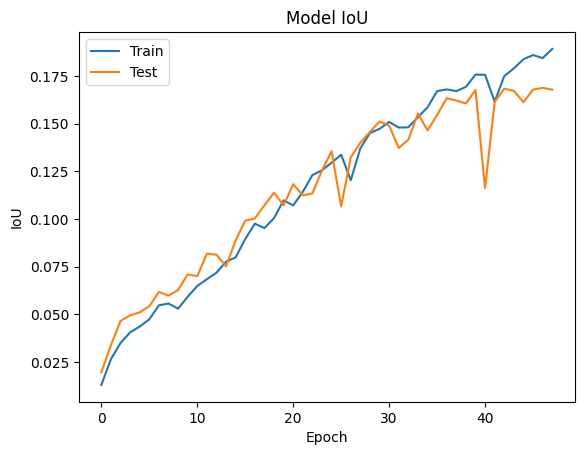

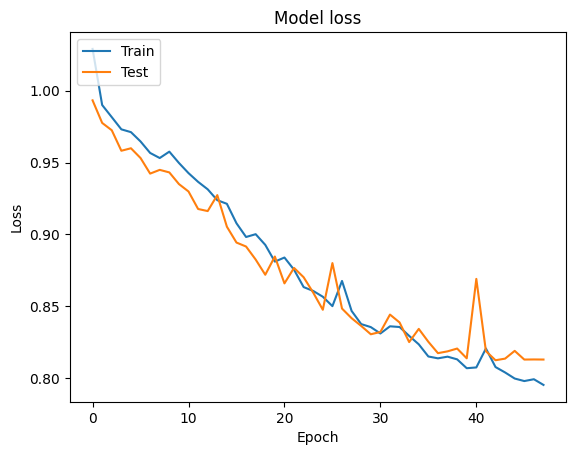

In [6]:

# plot the training history
import matplotlib.pyplot as plt
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['iou_score'])
    plt.plot(history.history['val_iou_score'])
    plt.title('Model IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


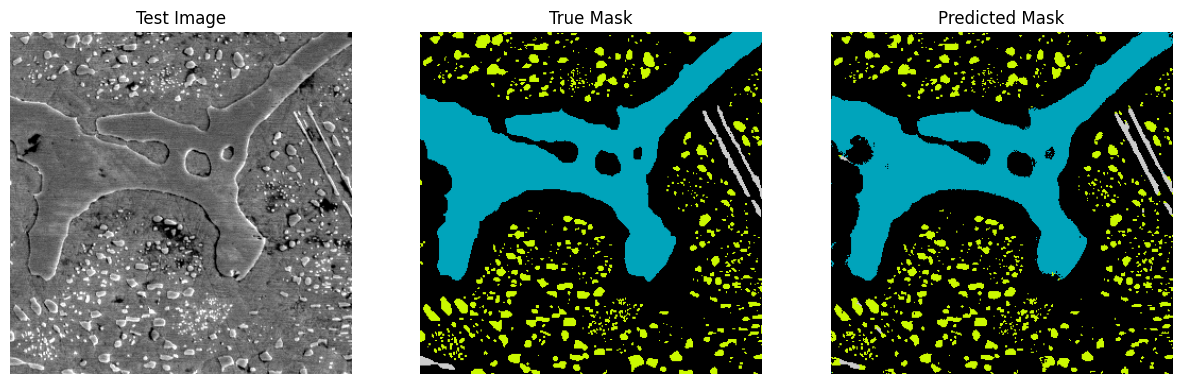

In [15]:
#random.seed(42)
# Pick a random test image
import matplotlib.pyplot as plt
idx = random.randint(0, X_test.shape[0] - 1)
test_img = X_test[idx]
true_mask = Y_test[idx]

# Predict the mask
pred_mask = model.predict(np.expand_dims(test_img, axis=0))
pred_mask = np.argmax(pred_mask, axis=-1)[0]

# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Test Image")
plt.imshow(test_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(true_mask, cmap='nipy_spectral', vmin=0, vmax=n_classes-1)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='nipy_spectral', vmin=0, vmax=n_classes-1)
plt.axis('off')

plt.show()
